# Mod 3 Final Project

## Student Info

- Name: Acusio Bivona
- Cohort: Part-Time Online 10/07/19
- Instructor: James Irving


<img src="https://raw.githubusercontent.com/jirvingphd/dsc-mod-3-project-online-ds-ft-100719/master/Northwind_ERD_updated.png">

In [1]:
!pip install -U fsds_100719
from fsds_100719.imports import *

fsds_1007219  v0.7.16 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [2]:
from functions import Cohen_d, find_outliers_IQR,find_outliers_Z

## Uncomment the line below to see the source code for the imported functions
##fs.ihelp(Cohen_d,False),fs.ihelp(find_outliers_IQR,False), fs.ihelp(find_outliers_Z,False)

In [3]:
import sqlite3
connect = sqlite3.connect('Northwind_small.sqlite')
cur = connect.cursor()

In [4]:
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


# HYPOTHESIS 1

> ***Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?***

- $H_0$: Discounts will not produce a statistically significant effect on the quantity of products sold.
- $H_1$: Including a discount on products will create a statistically significant effect on the quantity of those products sold.

## Create DataFrame

In [5]:
cur.execute("""SELECT * 
            FROM OrderDetail;""")
df_od = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])
df_od.head()
#Use dictionaries & GroupBy Statements

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


## Create Dictionaries for Each Discount Offered

In [6]:
data = {}
for discount in df_od['Discount'].unique():
    print(discount)
    data[discount] = df_od.groupby('Discount').get_group(discount)['Quantity']
    
data

0.0
0.15
0.05
0.2
0.25
0.1
0.02
0.03
0.04
0.06
0.01


{0.0: 0       12
 1       10
 2        5
 3        9
 4       40
         ..
 2147     2
 2148     2
 2151     1
 2153     4
 2154     2
 Name: Quantity, Length: 1317, dtype: int64, 0.15: 6       35
 7       15
 17      15
 18      21
 48      25
         ..
 2112    20
 2113    30
 2124    10
 2125    30
 2126     2
 Name: Quantity, Length: 157, dtype: int64, 0.05: 8        6
 9       15
 11      40
 12      25
 51      12
         ..
 2116    10
 2123    14
 2134     1
 2137     2
 2144     2
 Name: Quantity, Length: 185, dtype: int64, 0.2: 29      50
 30      65
 31       6
 40      12
 99      45
         ..
 2069    35
 2071    25
 2091    10
 2092    12
 2130    24
 Name: Quantity, Length: 161, dtype: int64, 0.25: 34      16
 36      15
 37      21
 43      60
 45      60
         ..
 2101     4
 2102    20
 2127    20
 2128    20
 2129    10
 Name: Quantity, Length: 154, dtype: int64, 0.1: 107     10
 108      3
 115     20
 116     24
 117      2
         ..
 2095    30
 2096  

## Outlier Removal & Normality Test

In [7]:
#Outlier Removal
#Can run normality test & equal variance test (if applicable)
from scipy import stats
clean_data = {}
for k, v in data.items():
    
    idx_outs = find_outliers_Z(v)
    dat_clean = v[~idx_outs].copy()
    if len(dat_clean) < 4:
        print(f"{k} only has {len(dat_clean)} rows. Removing group from dataset.")
    else: 
        stat, p = stats.shapiro(dat_clean)
        print(f"For {k} normal test, p = {round(p, 4)}, n = {len(dat_clean)}")
        clean_data[k] = dat_clean

For 0.0 normal test, p = 0.0, n = 1297
For 0.15 normal test, p = 0.0, n = 155
For 0.05 normal test, p = 0.0, n = 182
For 0.2 normal test, p = 0.0, n = 159
For 0.25 normal test, p = 0.0, n = 151
For 0.1 normal test, p = 0.0, n = 170
0.02 only has 2 rows. Removing group from dataset.
0.03 only has 3 rows. Removing group from dataset.
0.04 only has 1 rows. Removing group from dataset.
0.06 only has 1 rows. Removing group from dataset.
0.01 only has 1 rows. Removing group from dataset.


/Users/acusiobivona/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:2315: RuntimeWarning:

invalid value encountered in true_divide



### After running the normality test, it is evident the data is not normally distributed in each group. However, due to the large sample sizes in each group, we can safely ignore this assumption and move forward into the equal variance test.

## Equal Variance Test

In [8]:
empty_list = []
for k,v in clean_data.items():
    empty_list.append(v)

In [9]:
stats.levene(*empty_list)

LeveneResult(statistic=4.7429850894071715, pvalue=0.0002591859866634427)

### After running the test, we can conclude that this data does not have equal variance. Given this result along with the number of sample groups (6 groups), we will have to run a non-parametric ANOVA hypothesis test.

## Hypothesis Test - Non-Parametric ANOVA (Alpha = 0.05)

In [10]:
stats.kruskal(*empty_list)

KruskalResult(statistic=53.65085902244109, pvalue=2.472284921686678e-10)

### After running the hypothesis test, a very small (and thus signficant) p-value was recorded. Therefore, we can confidently reject the null hypothesis and perform a Tukey's Comparison test to see which groups are different.

## Tukey's Comparison Test

In [11]:
def prep_data_for_tukeys(data):
    """Accepts a dictionary with group names as the keys 
    and pandas series as the values. 
    
    Returns a dataframe ready for tukeys test:
    - with a 'data' column and a 'group' column for sms.stats.multicomp.pairwise_tukeyhsd 
    
    Example Use:
    df_tukey = prep_data_for_tukeys(grp_data)
    tukey = sms.stats.multicomp.pairwise_tukeyhsd(df_tukey['data'], df_tukey['group'])
    tukey.summary()
    """
    df_tukey = pd.DataFrame(columns=['data','group'])
    for k,v in  data.items():
        grp_df = v.rename('data').to_frame() 
        grp_df['group'] = k
        df_tukey=pd.concat([df_tukey, grp_df],axis=0)
        
    df_tukey['group'] = df_tukey['group'].astype('str')
    df_tukey['data'] = df_tukey['data'].astype('float')
    return df_tukey

In [12]:
best_data_ever = prep_data_for_tukeys(clean_data)
best_data_ever

,data,group
0,12.0,0.0
1,10.0,0.0
2,5.0,0.0
3,9.0,0.0
4,40.0,0.0
...,...,...
2095,30.0,0.1
2096,77.0,0.1
2098,25.0,0.1
2099,4.0,0.1


In [13]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print(pairwise_tukeyhsd(best_data_ever['data'].values, best_data_ever['group'].values))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0   0.05   6.0639  0.001  2.4368   9.691   True
   0.0    0.1   2.9654 0.2098 -0.7723  6.7031  False
   0.0   0.15   6.9176  0.001  3.0233 10.8119   True
   0.0    0.2   5.6293  0.001  1.7791  9.4796   True
   0.0   0.25   6.1416  0.001  2.2016 10.0817   True
  0.05    0.1  -3.0985 0.4621 -7.9861   1.789  False
  0.05   0.15   0.8537    0.9 -4.1547   5.862  False
  0.05    0.2  -0.4346    0.9 -5.4088  4.5396  False
  0.05   0.25   0.0777    0.9 -4.9663  5.1218  False
   0.1   0.15   3.9522 0.2311 -1.1368  9.0412  False
   0.1    0.2   2.6639 0.6409 -2.3915  7.7193  False
   0.1   0.25   3.1762 0.4872 -1.9479  8.3004  False
  0.15    0.2  -1.2883    0.9 -6.4605   3.884  False
  0.15   0.25  -0.7759    0.9 -6.0154  4.4635  False
   0.2   0.25   0.5123    0.9 -4.6945  5.7191  False
----------------------------------------------

### Based on the results of Tukey's Test, there is a clear & significant effect on product sales when a product includes a discount. Significant p-values were recorded for products sold when comparing the '0.0' discount group with every other discount group, except for the '0.1' group.

### As for comapring discounts against each other, there were no statistically significant effects. The strongest relationship was present between the '0.1' and '0.15' groups.

[Text(0, 0.5, 'Quantity'), Text(0.5, 0, 'Discount')]

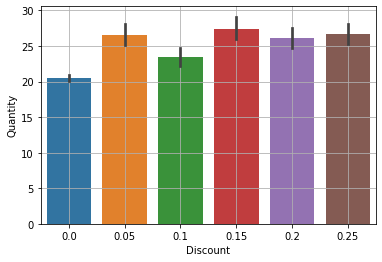

In [14]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=best_data_ever, x='group', y='data', ci=68, ax=ax)
ax.grid()
ax.get_figure().set_size_inches(6,4)

ax.set(xlabel='Discount', ylabel='Quantity')

### Recommendation: Based on the results, we have about the same number of products sold for both the 5% and 25% groups. But when we offer a 25% discount, we are losing more money. Therefore, I would suggest no longer offering 25% discounts.

# HYPOTHESIS 2

- $H_0$: There will be no statistically significant effect on units sold based on shipping region.
- $H_1$: Shipping Region will have a statistically significant effect on product units sold.

## Query Data

In [15]:
cur.execute("""SELECT *
            FROM OrderDetail""")
cur.description
df_order_detail = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])
df_order_detail

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [16]:
cur.execute("""SELECT *
            FROM 'Order'""")
cur.description
df_order = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])
df_order

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,11073,PERIC,2,2014-05-05,2014-06-02,None,2,24.95,Pericles Comidas clásicas,Calle Dr. Jorge Cash 321,México D.F.,Central America,05033,Mexico
826,11074,SIMOB,7,2014-05-06,2014-06-03,None,2,18.44,Simons bistro,Vinbæltet 34,Kobenhavn,Northern Europe,1734,Denmark
827,11075,RICSU,8,2014-05-06,2014-06-03,None,2,6.19,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
828,11076,BONAP,4,2014-05-06,2014-06-03,None,2,38.28,Bon app',"12, rue des Bouchers",Marseille,Western Europe,13008,France


## Merge Tables

In [18]:
df_region_use = pd.merge(df_order, df_order_detail, left_on='Id', right_on='OrderId')
df_region_use.head()

,Id_x,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id_y,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/11,10248,11,14.0,12,0.0
1,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/42,10248,42,9.8,10,0.0
2,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/72,10248,72,34.8,5,0.0
3,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/14,10249,14,18.6,9,0.0
4,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/51,10249,51,42.4,40,0.0


## Create Dictionaries for Shipping Regions

In [19]:
data_region_products = {}
for region in df_region_use['ShipRegion'].unique():
    print(region)
    data_region_products[region] = df_region_use.groupby('ShipRegion').get_group(region)['Quantity']
    
data_region_products

Western Europe
South America
Central America
North America
Northern Europe
Scandinavia
Southern Europe
British Isles
Eastern Europe


{'Western Europe': 0       12
 1       10
 2        5
 3        9
 4       40
         ..
 2125    30
 2126     2
 2127    20
 2128    20
 2129    10
 Name: Quantity, Length: 745, dtype: int64, 'South America': 5       10
 6       35
 7       15
 14      20
 15      42
         ..
 2107     8
 2108    36
 2109    28
 2115    15
 2116    10
 Name: Quantity, Length: 355, dtype: int64, 'Central America': 32      10
 33       1
 74      15
 75      10
 119     12
         ..
 1927    20
 1928     4
 2110    20
 2121    10
 2122    20
 Name: Quantity, Length: 72, dtype: int64, 'North America': 40      12
 41      15
 42       2
 57      60
 58      20
         ..
 2150     2
 2151     1
 2152     2
 2153     4
 2154     2
 Name: Quantity, Length: 427, dtype: int64, 'Northern Europe': 47      35
 48      25
 78      16
 79      15
 80       8
         ..
 1944    25
 1945    25
 1946     6
 2065    50
 2123    14
 Name: Quantity, Length: 143, dtype: int64, 'Scandinavia': 51      12
 59      

## Outlier Removal & Normality Test

In [20]:
clean_data_region_prod = {}
clean_list_region_prod = []
for k, v in data_region_products.items():
    
    idx_outs = find_outliers_Z(v)
    data_clean = v[~idx_outs].copy()
    clean_list_region_prod.append(data_clean)
    stat, p = stats.shapiro(data_clean)
    print(f"For {k} normal test, p = {round(p, 4)}, n = {len(data_clean)}")
    clean_data_region_prod[k] = data_clean

For Western Europe normal test, p = 0.0, n = 731
For South America normal test, p = 0.0, n = 350
For Central America normal test, p = 0.0007, n = 71
For North America normal test, p = 0.0, n = 417
For Northern Europe normal test, p = 0.0, n = 143
For Scandinavia normal test, p = 0.0001, n = 69
For Southern Europe normal test, p = 0.0, n = 136
For British Isles normal test, p = 0.0, n = 185
For Eastern Europe normal test, p = 0.084, n = 16


### After testing for normality, we can conclude that this data is not normally distributed. We will now test for equal variance because our groups have large enough samples.

## Test for Equal Variance

In [21]:
empty_list_reg = []
for k,v in clean_data_region_prod.items():
    empty_list_reg.append(v)

In [22]:
stats.levene(*empty_list_reg)

LeveneResult(statistic=10.413760942601051, pvalue=2.0992306280336536e-14)

### This test result shows that our data does not have equal variance. Therefore, we will test this data using the Non-Parametric ANOVA test.

## Hypothesis Test: Non-Parametric ANOVA (Alpha = .05)

In [23]:
stats.kruskal(*clean_list_region_prod)

KruskalResult(statistic=111.8182551112351, pvalue=1.6098142288244464e-20)

### We were able to achieve a significant p-value from this hypothesis test. Therefore, we can reject our null hypothesis and accept that shipping region has a statistically significant effect on product units sold. Next, we will run a Tukey's Test to see if any region has signficant effects when compared to another region.

## Tukey's Test

In [24]:
df_reg_product_tukey = prep_data_for_tukeys(clean_data_region_prod)

In [25]:
results = pairwise_tukeyhsd(df_reg_product_tukey['data'].values, df_reg_product_tukey['group'].values)
results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
British Isles,Central America,-8.0298,0.0096,-14.9408,-1.1188,True
British Isles,Eastern Europe,-8.9497,0.4395,-21.8496,3.9503,False
British Isles,North America,2.7558,0.5634,-1.6172,7.1288,False
British Isles,Northern Europe,2.049,0.9,-3.4631,7.5612,False
British Isles,Scandinavia,-7.3274,0.0313,-14.3104,-0.3444,True
British Isles,South America,-1.2707,0.9,-5.7705,3.2291,False
British Isles,Southern Europe,-6.8872,0.0043,-12.4787,-1.2956,True
British Isles,Western Europe,3.8876,0.0755,-0.1865,7.9618,False
Central America,Eastern Europe,-0.9199,0.9,-14.6195,12.7797,False
Central America,North America,10.7856,0.001,4.4301,17.1411,True


In [29]:
df_reg_prod_final = pd.DataFrame(data=results._results_table.data[1:], columns=results._results_table.data[0])
pd.set_option('display.max_rows', 999)
df_reg_prod_final.loc[df_reg_prod_final['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
0,British Isles,Central America,-8.0298,0.0096,-14.9408,-1.1188,True
4,British Isles,Scandinavia,-7.3274,0.0313,-14.3104,-0.3444,True
6,British Isles,Southern Europe,-6.8872,0.0043,-12.4787,-1.2956,True
9,Central America,North America,10.7856,0.0010,4.4301,17.1411,True
10,Central America,Northern Europe,10.0788,0.0010,2.8918,17.2658,True
12,Central America,South America,6.7590,0.0314,0.3156,13.2024,True
14,Central America,Western Europe,11.9174,0.0010,5.7637,18.0711,True
20,Eastern Europe,Western Europe,12.8373,0.0392,0.3267,25.3479,True
22,North America,Scandinavia,-10.0832,0.0010,-16.5169,-3.6495,True
23,North America,South America,-4.0266,0.0148,-7.6152,-0.4379,True


### The Tukey's Test clearly shows that certain shipping regions have statistical significance when compared with another region. The strongest relationships are as follows:

### - Central America & North America
### - Central America & Northern Europe
### - Central America & Western Europe
### - North America & Scandinavia
### - North America & Southern Europe
### - Northern Europe & Southern Europe
### - Scandinavia & Western Europe
### - South America & Western Europe
### - Southern Europe & Western Europe

[Text(0, 0.5, 'Quantity'), Text(0.5, 0, 'Shipping Region')]

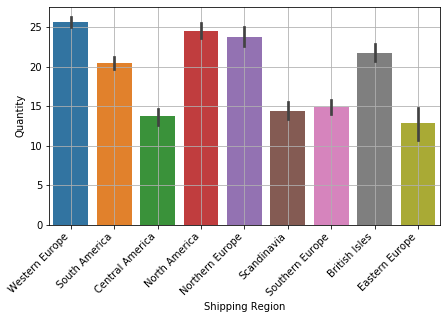

In [30]:
fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(data=df_reg_product_tukey, x='group', y='data', ci=68, ax=ax)
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set(xlabel='Shipping Region', ylabel='Quantity')

### Recommendation: After analyzing these results, my primary recommendation would be to try and increase sales where products are shipped in Western Europe, North America, and Northern Europe. These 3 regions seem to be our biggest players and I believe the best decision would be to further invest marketing into those three regions so that we can further improve sales and increase revenue.

# HYPOTHESIS 3

- $H_0$: Revenue will not be statistically affected by applying discounts to each product.
- $H_1$: For each product, discounts will result in a statistically significant effect on revenue. 

## Create Function to Calculate Revenue

In [31]:
def revenue(x,y):
    """This function will be used to calculate the revenue generated for each product sold.
    x = UnitPrice
    y = Quantity"""
    return x*y

## Query Data

In [32]:
cur.execute("""SELECT * 
            FROM OrderDetail
            ORDER BY ProductID ASC;""")
df_revenue = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])
df_revenue.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10285/1,10285,1,14.4,45,0.20
1,10294/1,10294,1,14.4,18,0.00
2,10317/1,10317,1,14.4,20,0.00
3,10348/1,10348,1,14.4,15,0.15
4,10354/1,10354,1,14.4,12,0.00


In [33]:
df_revenue['Revenue'] = revenue(df_revenue['UnitPrice'], df_revenue['Quantity'])
df_revenue.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10285/1,10285,1,14.4,45,0.20,648.0
1,10294/1,10294,1,14.4,18,0.00,259.2
2,10317/1,10317,1,14.4,20,0.00,288.0
3,10348/1,10348,1,14.4,15,0.15,216.0
4,10354/1,10354,1,14.4,12,0.00,172.8


## Create Dictionaries for each Product

In [34]:
data_2 = {}
for product in df_revenue['ProductId'].unique():
    print(product)
    data_2[product] = df_revenue.groupby('ProductId').get_group(product)['Revenue']
    
data_2

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77


{1: 0      648.0
 1      259.2
 2      288.0
 3      216.0
 4      172.8
 5      216.0
 6      144.0
 7      345.6
 8      216.0
 9      720.0
 10     144.0
 11     180.0
 12     360.0
 13      54.0
 14     108.0
 15     450.0
 16     270.0
 17     630.0
 18     540.0
 19      90.0
 20     900.0
 21     144.0
 22      72.0
 23    1440.0
 24     360.0
 25     720.0
 26     360.0
 27     180.0
 28    1080.0
 29     378.0
 30      72.0
 31      36.0
 32     144.0
 33     180.0
 34     810.0
 35     180.0
 36     450.0
 37     720.0
 Name: Revenue, dtype: float64, 2: 38     304.0
 39     760.0
 40     532.0
 41     608.0
 42     380.0
 43     106.4
 44     364.8
 45     380.0
 46     912.0
 47     152.0
 48     684.0
 49     608.0
 50     304.0
 51     228.0
 52     190.0
 53     380.0
 54     570.0
 55     950.0
 56      95.0
 57     570.0
 58      57.0
 59     285.0
 60     760.0
 61     285.0
 62     190.0
 63     380.0
 64     228.0
 65     190.0
 66      95.0
 67     285.0
 68     380

## Outlier Removal & Normality Test

In [35]:
clean_data_revenue = {}
clean_list = []
for k, v in data_2.items():
    
    idx_outs = find_outliers_Z(v)
    data_clean = v[~idx_outs].copy()
    clean_list.append(data_clean)
    stat, p = stats.shapiro(data_clean)
    print(f"For {k} normal test, p = {round(p, 4)}, n = {len(data_clean)}")
    clean_data_revenue[k] = data_clean

For 1 normal test, p = 0.001, n = 37
For 2 normal test, p = 0.0029, n = 43
For 3 normal test, p = 0.4441, n = 12
For 4 normal test, p = 0.0331, n = 20
For 5 normal test, p = 0.1788, n = 10
For 6 normal test, p = 0.2286, n = 12
For 7 normal test, p = 0.0023, n = 29
For 8 normal test, p = 0.3593, n = 13
For 9 normal test, p = 0.0947, n = 5
For 10 normal test, p = 0.0, n = 32
For 11 normal test, p = 0.0003, n = 38
For 12 normal test, p = 0.2891, n = 13
For 13 normal test, p = 0.0, n = 40
For 14 normal test, p = 0.1238, n = 21
For 15 normal test, p = 0.1803, n = 6
For 16 normal test, p = 0.0587, n = 43
For 17 normal test, p = 0.0018, n = 36
For 18 normal test, p = 0.067, n = 27
For 19 normal test, p = 0.0003, n = 36
For 20 normal test, p = 0.1326, n = 16
For 21 normal test, p = 0.0051, n = 39
For 22 normal test, p = 0.3411, n = 14
For 23 normal test, p = 0.0355, n = 20
For 24 normal test, p = 0.0001, n = 49
For 25 normal test, p = 0.0049, n = 18
For 26 normal test, p = 0.017, n = 32
For 27

### After running this normality test, we received a mixed bag of results in terms of significant or insignificant p-values for each product. Also, there are a few groups that have a small number of samples (<20). Therefore we will move past testing for equal variance and perform the non-parametric version of an ANOVA test.

## Hypothesis Test: Non-Parametric ANOVA (Alpha = .05)

In [36]:
stats.kruskal(*clean_list)

KruskalResult(statistic=947.2946660406544, pvalue=1.5343308499647505e-150)

### With a very significant p-value being recorded, we can confidently reject our null hypothesis and state that discounts have a signifcant statistical effect on revenue. Now, we will run another Tukey's test to compare the signficance of revenue changes between products.

## Tukey's Test

In [37]:
df_rev_tukey = prep_data_for_tukeys(clean_data_revenue)

In [38]:
results = pairwise_tukeyhsd(df_rev_tukey['data'].values, df_rev_tukey['group'].values)
results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,10,248.0441,0.9,-431.6704,927.7585,False
1,11,18.8799,0.9,-631.4231,669.183,False
1,12,350.484,0.9,-557.3162,1258.2842,False
1,13,-216.1022,0.9,-858.3347,426.1304,False
1,14,-13.4907,0.9,-782.7652,755.7837,False
1,15,-44.7122,0.9,-1283.8954,1194.4711,False
1,16,89.039,0.9,-542.3365,720.4145,False
1,17,530.3212,0.5024,-128.8332,1189.4755,False
1,18,837.7601,0.0022,125.0957,1550.4244,True
1,19,-192.0872,0.9,-851.2415,467.0672,False


In [39]:
cool_df = pd.DataFrame(data=results._results_table.data[1:], columns=results._results_table.data[0])
pd.set_option('display.max_rows', 999)
cool_df.loc[cool_df['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
8,1,18,837.7601,0.0022,125.0957,1550.4244,True
11,1,20,1130.2753,0.0010,287.8045,1972.7462,True
18,1,27,1345.4267,0.0010,298.9379,2391.9156,True
20,1,29,2163.7862,0.0010,1478.2182,2849.3542,True
30,1,38,5902.3795,0.0010,5164.4137,6640.3453,True
45,1,51,663.1063,0.0369,12.8032,1313.4093,True
53,1,59,898.1532,0.0010,292.5750,1503.7315,True
57,1,62,629.2910,0.0386,10.4663,1248.1158,True
75,1,9,1418.4378,0.0197,76.8578,2760.0179,True
86,10,20,882.2312,0.0348,20.1197,1744.3428,True


### This Tukey's Test shows that there is a large number of products that have statistical signficnance when compared against each other when speaking in terms of revenue.

In [70]:
means = df_rev_tukey.groupby('group').mean().sort_values(by='data', ascending=False)

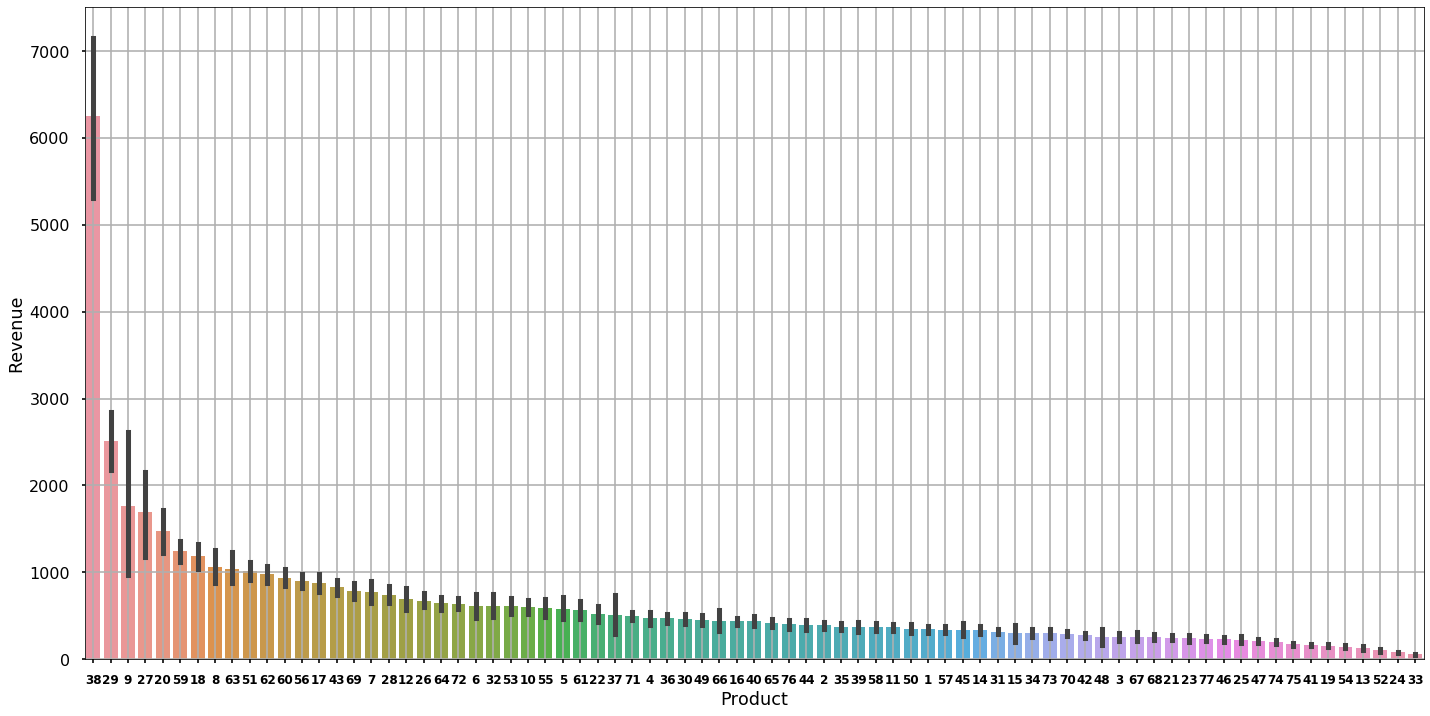

In [74]:
with plt.style.context('seaborn-poster'):
    
    fig, ax = plt.subplots(figsize=(24,12))
    sns.barplot(data=df_rev_tukey, x='group', y='data', ci=68, ax=ax, order=list(means.index))
    ax.grid()
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
    ax.set(xlabel='Product', ylabel='Revenue')

### Recommendation: From the Tukey's Test, it is very clear that there is one product that is far outperforming all others - product 38. Therefore, my recommendation would be to promote and market product 38 as much as possible to further increase sales, and thus increase revenue.

# HYPOTHESIS 4

- $H_0$: Shipping Region will not have a statistically signficant effect on Product Revenue.
- $H_1$: Shipping Region will have a statistically significant effect on Product Revenue.

## Query Data

In [41]:
cur.execute("""SELECT *
            FROM OrderDetail""")
cur.description
df_order_detail = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])
df_order_detail

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [42]:
cur.execute("""SELECT *
            FROM 'Order'""")
cur.description
df_order = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])
df_order

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
5,10253,HANAR,3,2012-07-10,2012-07-24,2012-07-16,2,58.17,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
6,10254,CHOPS,5,2012-07-11,2012-08-08,2012-07-23,2,22.98,Chop-suey Chinese,Hauptstr. 31,Bern,Western Europe,3012,Switzerland
7,10255,RICSU,9,2012-07-12,2012-08-09,2012-07-15,3,148.33,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
8,10256,WELLI,3,2012-07-15,2012-08-12,2012-07-17,2,13.97,Wellington Importadora,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil
9,10257,HILAA,4,2012-07-16,2012-08-13,2012-07-22,3,81.91,HILARION-Abastos,Carrera 22 con Ave. Carlos Soublette #8-35,San Cristóbal,South America,5022,Venezuela


## Merge the Two Tables

In [43]:
df_order_use = pd.merge(df_order, df_order_detail, left_on='Id', right_on='OrderId')
df_order_use.head()

,Id_x,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id_y,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/11,10248,11,14.0,12,0.0
1,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/42,10248,42,9.8,10,0.0
2,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/72,10248,72,34.8,5,0.0
3,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/14,10249,14,18.6,9,0.0
4,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/51,10249,51,42.4,40,0.0


## Create Revenue Column and Add to Table

In [44]:
df_order_use['Revenue'] = revenue(df_order_use['UnitPrice'], df_order_use['Quantity'])
df_order_use.head()

,Id_x,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,...,ShipRegion,ShipPostalCode,ShipCountry,Id_y,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,...,Western Europe,51100,France,10248/11,10248,11,14.0,12,0.0,168.0
1,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,...,Western Europe,51100,France,10248/42,10248,42,9.8,10,0.0,98.0
2,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,...,Western Europe,51100,France,10248/72,10248,72,34.8,5,0.0,174.0
3,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,...,Western Europe,44087,Germany,10249/14,10249,14,18.6,9,0.0,167.4
4,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,...,Western Europe,44087,Germany,10249/51,10249,51,42.4,40,0.0,1696.0


In [45]:
df_order_use['ShipRegion'].unique()
# 9 shipping locations

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

## Create Dictionaries for Each Region

In [46]:
data_region = {}
for region in df_order_use['ShipRegion'].unique():
    print(region)
    data_region[region] = df_order_use.groupby('ShipRegion').get_group(region)['Revenue']
    
data_region

Western Europe
South America
Central America
North America
Northern Europe
Scandinavia
Southern Europe
British Isles
Eastern Europe


{'Western Europe': 0         168.00
 1          98.00
 2         174.00
 3         167.40
 4        1696.00
 8         100.80
 9         234.00
 10        336.00
 11       2592.00
 12         50.00
 13       1088.00
 17         54.00
 18        403.20
 19        168.00
 20        304.00
 21        486.50
 22        380.00
 23       1320.00
 29        760.00
 30       1105.00
 31        153.60
 34        123.20
 35        780.00
 36        591.00
 37        252.00
 43        834.00
 44        100.80
 45       1242.00
 46        288.00
 49        936.00
 50        240.00
 52        735.00
 53       3080.00
 54        216.00
 65        595.20
 66        150.00
 67         40.00
 68        882.00
 69        475.20
 70        344.00
 71        194.60
 76        728.00
 77        472.80
 82        468.00
 95        526.50
 96        325.50
 97        544.00
 98         56.00
 99        648.00
 100       588.00
 101       943.20
 102      1440.00
 103      1576.00
 128       121.60
 132      

## Outlier Removal and Normality Testing

In [47]:
clean_data_region = {}
clean_list_region = []
for k, v in data_region.items():
    
    idx_outs = find_outliers_Z(v)
    data_clean = v[~idx_outs].copy()
    clean_list_region.append(data_clean)
    stat, p = stats.shapiro(data_clean)
    print(f"For {k} normal test, p = {round(p, 4)}, n = {len(data_clean)}")
    clean_data_region[k] = data_clean

For Western Europe normal test, p = 0.0, n = 734
For South America normal test, p = 0.0, n = 353
For Central America normal test, p = 0.0, n = 71
For North America normal test, p = 0.0, n = 419
For Northern Europe normal test, p = 0.0, n = 141
For Scandinavia normal test, p = 0.0, n = 69
For Southern Europe normal test, p = 0.0, n = 134
For British Isles normal test, p = 0.0, n = 186
For Eastern Europe normal test, p = 0.0386, n = 16


### Our normality test shows that the data is not normally distributed, so we will test for equal variance.

## Equal Variance Test

In [48]:
empty_list_2 = []
for k,v in clean_data_region.items():
    empty_list_2.append(v)

In [49]:
stats.levene(*empty_list_2)

LeveneResult(statistic=8.78556378723223, pvalue=6.963976436546475e-12)

### Running this test shows that there is not equal variance, so we will once again have to use the non-parametric version of the ANOVA to test our hypothesis.

## Hypothesis Test: Non-Parametric ANOVA (Alpha = .05)

In [50]:
stats.kruskal(*clean_list_region)

KruskalResult(statistic=85.91867392774088, pvalue=3.12379890853068e-15)

### Based on our p-value, we can confidently reject our null hypothesis and accept our alternative hypothesis, stating that shipping region does have a statistically significant effect on product revenue.

## Tukey's Test

In [51]:
df_reg_tukey = prep_data_for_tukeys(clean_data_region)

In [52]:
results = pairwise_tukeyhsd(df_reg_tukey['data'].values, df_reg_tukey['group'].values)
results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
British Isles,Central America,-209.6348,0.1729,-456.654,37.3843,False
British Isles,Eastern Europe,-272.2816,0.6387,-733.6086,189.0454,False
British Isles,North America,127.0945,0.2184,-28.9196,283.1086,False
British Isles,Northern Europe,57.1591,0.9,-140.564,254.8822,False
British Isles,Scandinavia,-153.8169,0.5896,-403.4135,95.7797,False
British Isles,South America,-40.7325,0.9,-201.1679,119.7029,False
British Isles,Southern Europe,-183.0726,0.1065,-383.7118,17.5666,False
British Isles,Western Europe,133.5464,0.1011,-11.8117,278.9044,False
Central America,Eastern Europe,-62.6468,0.9,-552.6739,427.3803,False
Central America,North America,336.7293,0.001,109.4754,563.9833,True


In [53]:
cool_df = pd.DataFrame(data=results._results_table.data[1:], columns=results._results_table.data[0])
pd.set_option('display.max_rows', 999)
cool_df.loc[cool_df['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
9,Central America,North America,336.7293,0.0010,109.4754,563.9833,True
10,Central America,Northern Europe,266.7939,0.0359,9.1150,524.4728,True
14,Central America,Western Europe,343.1812,0.0010,123.1064,563.2561,True
22,North America,Scandinavia,-280.9114,0.0048,-510.9645,-50.8584,True
23,North America,South America,-167.8271,0.0016,-295.7546,-39.8995,True
24,North America,Southern Europe,-310.1671,0.0010,-485.8999,-134.4343,True
28,Northern Europe,Southern Europe,-240.2317,0.0144,-453.8577,-26.6057,True
32,Scandinavia,Western Europe,287.3633,0.0021,64.3992,510.3273,True
34,South America,Western Europe,174.2789,0.0010,59.5880,288.9699,True
35,Southern Europe,Western Europe,316.6190,0.0010,150.2742,482.9637,True


### Our Tukey's Test shows that there are some strong effects on product revenue when comparing regions against each other, particularly in the following cases:

### - Central America & North America
### - Central America & Western Europe
### - North America & Southern Europe
### - South America & Western Europe
### - Southern Europe & Western Europe

[Text(0, 0.5, 'Revenue'), Text(0.5, 0, 'Shipping Region')]

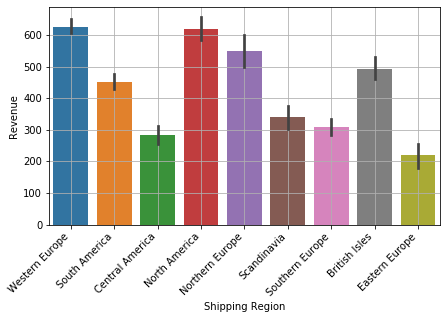

In [54]:
fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(data=df_reg_tukey, x='group', y='data', ci=68, ax=ax)
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set(xlabel='Shipping Region', ylabel='Revenue')

### Recommendation: I have two recommendations. First, I would halt shipping products out of Eastern Europe. That region is significantly underperforming. I would consider taking the products & resources there and consolidating them with another region (perhaps Southern Europe) so that we can make shipping more efficient.

### On the flipside, I believe we should invest more into shipping out of Western Europe & North America because they are the two clear-cut performers when it comes to shipping. If the budget allows, we should also consider investing more into Northern Europe as well to see if we can have a bump in performance.

# Conclusion

### Our mission for Northwind was to come up with 4 business oriented hypotheses in the attempt to test them, achieve statistically significant results, and then make recommendation how to apply our findings to improve the company's performance. Thankfully, we were able generate significant results with each test, and make the following recommendations:

### - Remove the use of 25% discounts on all products
### - Invest into the Western Europe, North American, and Northern Europe shipping regions to further increase sales and profits
### - Heavily market product 38 using discounts
### - Stop shipping products out of Eastern Europe